In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from analysis import *
from functools import reduce

# Recover graphs of 2017 (jan -> aug)

In [2]:
gateways_jan = ['4766','46606','16509','38895','19551','57127','17511','9371','53667','14618','13335','45102','60781','26496','37907']

In [2]:
ripple_graph_jan, caida_graph_jan, gateways_jan = build_graphs('Ripple/gateway_links.csv', 'Caida/20170101.as-rel2.txt')
ripple_graph_feb, caida_graph_feb, gateways_feb = build_graphs('Ripple/gateway_links.csv', 'Caida/20170201.as-rel2.txt')
ripple_graph_mar, caida_graph_mar, gateways_mar = build_graphs('Ripple/gateway_links.csv', 'Caida/20170301.as-rel2.txt')
ripple_graph_apr, caida_graph_apr, gateways_apr = build_graphs('Ripple/gateway_links.csv', 'Caida/20170401.as-rel2.txt')
ripple_graph_may, caida_graph_may, gateways_may = build_graphs('Ripple/gateway_links.csv', 'Caida/20170501.as-rel2.txt')
ripple_graph_jun, caida_graph_jun, gateways_jun = build_graphs('Ripple/gateway_links.csv', 'Caida/20170601.as-rel2.txt')
ripple_graph_jul, caida_graph_jul, gateways_jul = build_graphs('Ripple/gateway_links.csv', 'Caida/20170701.as-rel2.txt')
ripple_graph_aug, caida_graph_aug, gateways_aug = build_graphs('Ripple/gateway_links.csv', 'Caida/20170801.as-rel2.txt')
graphs_list = [ripple_graph_jan,ripple_graph_feb,ripple_graph_mar,ripple_graph_apr,ripple_graph_may,ripple_graph_jun,ripple_graph_jul,ripple_graph_aug]

In [3]:
months = ['January','February','March','April','May','June','July','August']

In [4]:
for i in range(len(months)):
    nx.write_gexf(graphs_list[i], 'graph'+str(months[i])+'.gexf')

In [4]:
graphs_list = []
for i in range(len(months)):
    graphs_list.append(nx.read_gexf('graph'+str(months[i])+'.gexf'))

In [5]:
graph_stats = pd.DataFrame(columns=['month', 'nodes', 'edges'])
for i in range(len(graphs_list)):
    graph_stats = graph_stats.append({'month': months[i], 'nodes': len(graphs_list[i].nodes), 'edges': len(graphs_list[i].edges)}, ignore_index=True)   

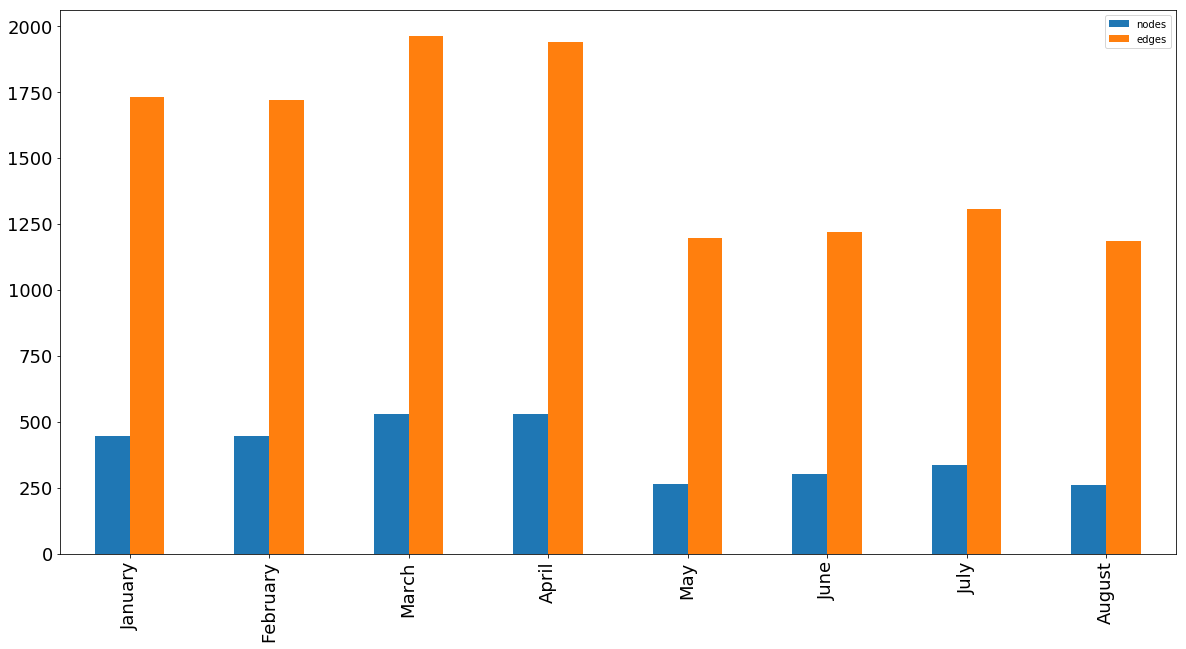

In [6]:
graph_stats.set_index('month').plot.bar(figsize=(20,10),fontsize=18)
plt.xlabel('')
plt.savefig('report/graph-time.eps', format='eps')
plt.show()

# Recover transactions

In [7]:
transactions = get_transactions('Ripple/transactions_processed.csv')

In [8]:
transactions_jan = transactions[transactions['date'] == '2017-01']
transactions_feb = transactions[transactions['date'] == '2017-02']
transactions_mar = transactions[transactions['date'] == '2017-03']
transactions_apr = transactions[transactions['date'] == '2017-04']
transactions_may = transactions[transactions['date'] == '2017-05']
transactions_jun = transactions[transactions['date'] == '2017-06']
transactions_jul = transactions[transactions['date'] == '2017-07']
transactions_aug = transactions[transactions['date'] == '2017-08']
transactions_list = [transactions_jan, transactions_feb, transactions_mar, transactions_apr, transactions_may, transactions_jun, transactions_jul, transactions_aug]

In [9]:
transactions_distrib = [(months[i],transactions_list[i]['amount'].sum()*100/transactions['amount'].sum()) for i in range(len(transactions_list))]

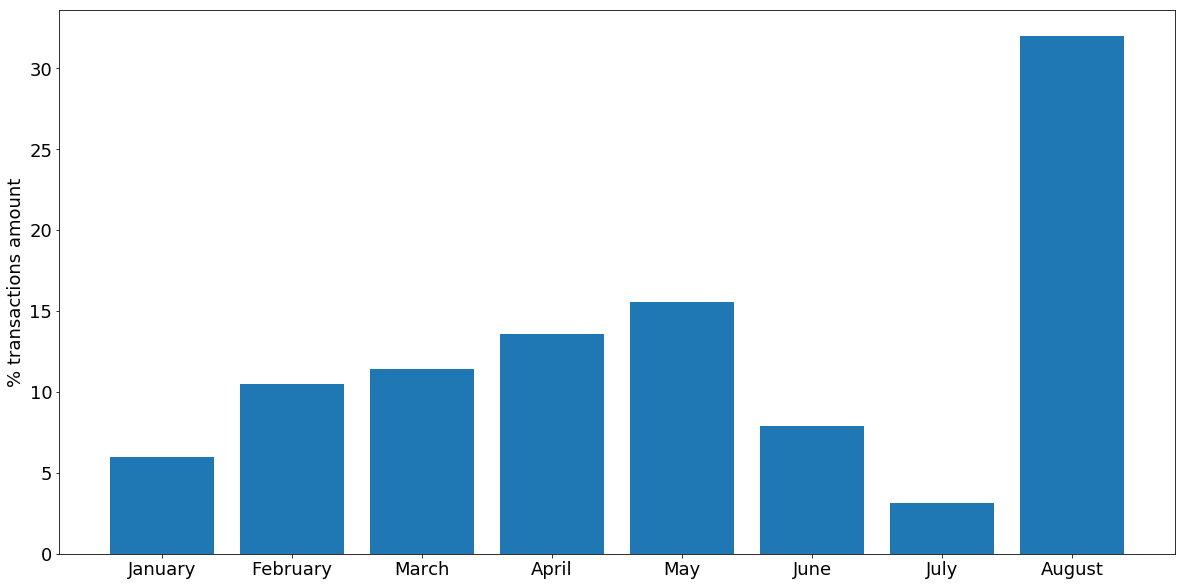

In [10]:
plt.figure(figsize=(20,10))
plt.bar(range(len(transactions_distrib)), [val[1] for val in transactions_distrib], align='center')
plt.xticks(range(len(transactions_distrib)), [val[0] for val in transactions_distrib], fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.savefig('report/transactions-bar.eps', format='eps')
plt.show()

In [11]:
transactions_plot = transactions.groupby('sender').sum().add(transactions.groupby('receiver').sum(), fill_value=0)
transactions_plot['amount'] = transactions_plot['amount'].apply(lambda x: 100*x/transactions['amount'].sum())

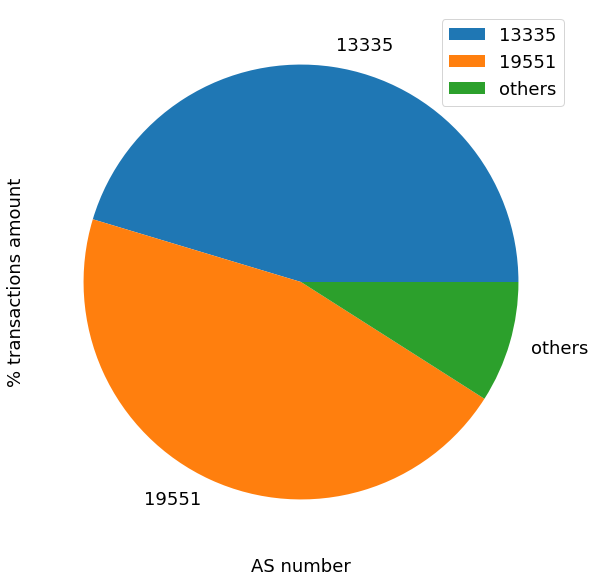

In [12]:
pie_plot = transactions_plot.reset_index().append({'index':'others', 'amount':transactions_plot[transactions_plot['amount'] < 10].sum().values[0]}, ignore_index=True).set_index('index')
pie_plot = pie_plot[pie_plot['amount'] >= 10]
pie_plot.plot.pie(subplots=True,figsize=(20,10),fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.xlabel('AS number', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('report/transactions-pie.eps', format='eps')

In [13]:
gateways_nodes = set()
gateways_nodes.update(transactions['sender'])
gateways_nodes.update(transactions['receiver'])

In [14]:
def count_direct_links(nodes, graph):
    links = 0
    for n1 in nodes:
        for n2 in nodes:
            if(n1 != n2 and graph.has_edge(n1, n2)):
                links += 1
    return links    

In [15]:
def are_in(nodes, graph):
    count = 0
    for n in nodes:
        if n in graph:
            count += 1
    return count

In [16]:
graph_stats = pd.DataFrame(columns=['month', 'gateways', 'direct_links'])
for i in range(len(graphs_list)):
    graph_stats = graph_stats.append({'month': months[i], 'gateways': are_in(gateways_nodes,graphs_list[i]), 'direct_links': count_direct_links(gateways_nodes,graphs_list[i])}, ignore_index=True)   

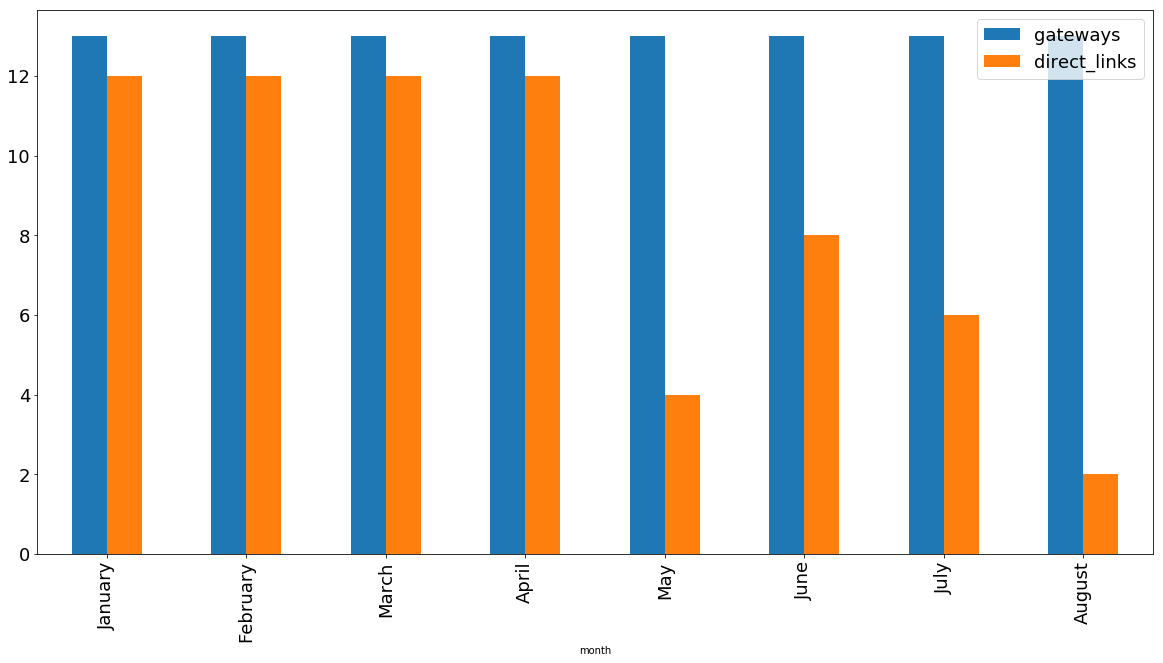

In [17]:
graph_stats.set_index('month').plot.bar(figsize=(20,10),fontsize=18)
plt.legend(fontsize=18)
plt.savefig('report/graph.eps', format='eps')

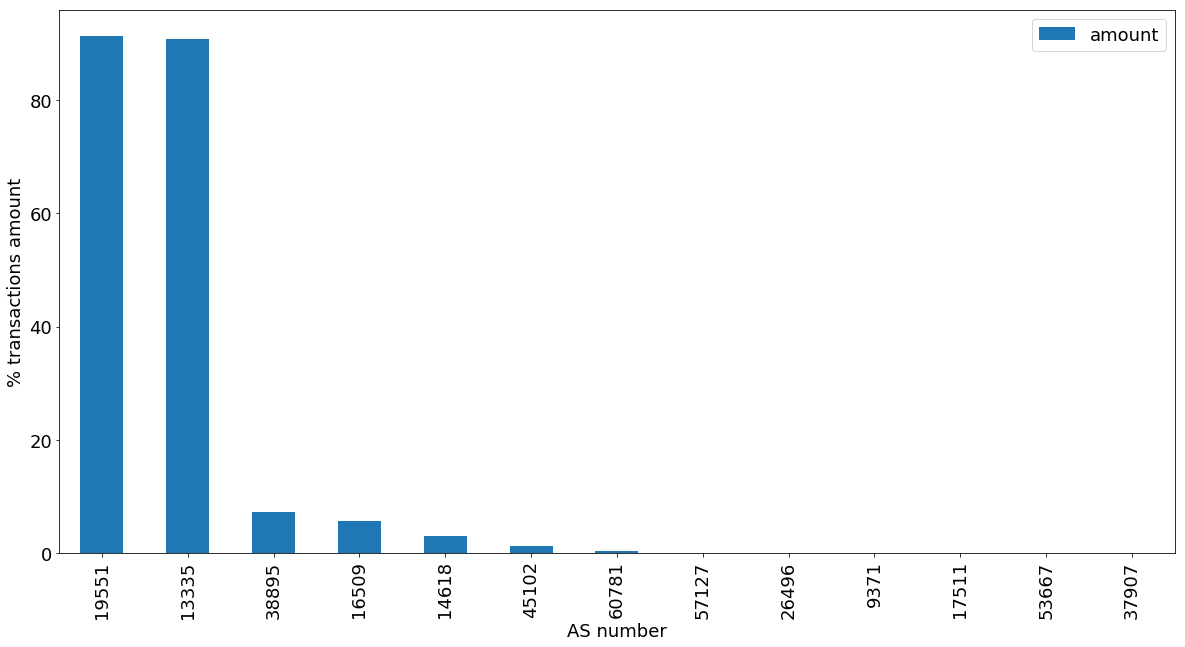

In [18]:
top_transactions = transactions.groupby('sender').sum().add(transactions.groupby('receiver').sum(), fill_value=0)
top_transactions['amount'] = top_transactions.apply(lambda x: x*100/transactions['amount'].sum())
top_transactions.sort_values(by='amount', ascending=False).plot.bar(figsize=(20,10), fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.xlabel('AS number', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('report/transactions-compare-bar.eps', format='eps')

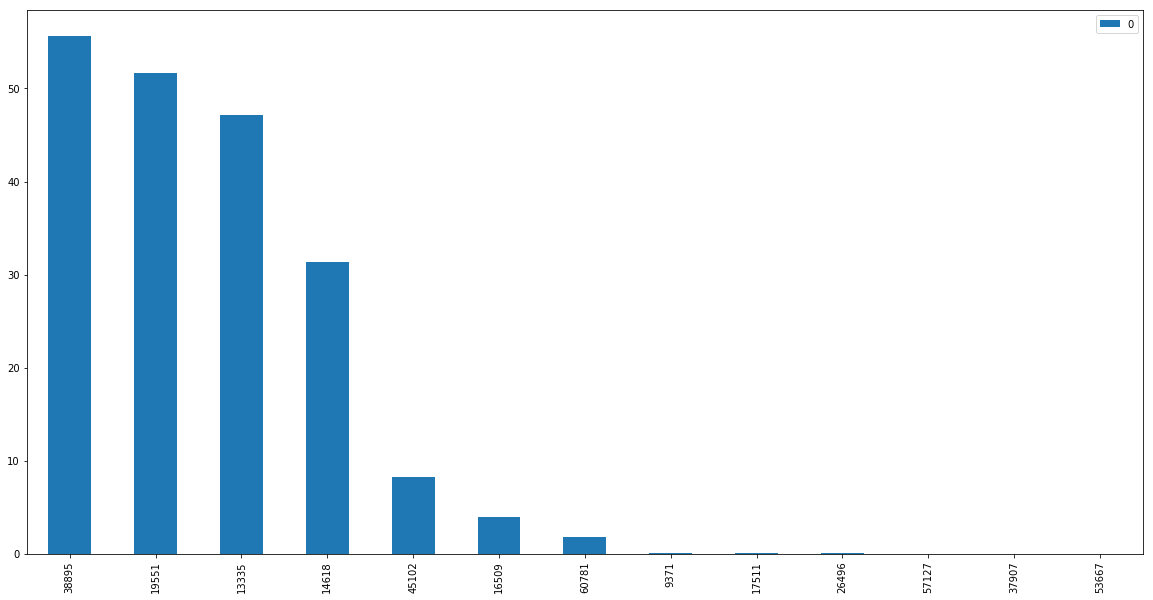

In [19]:
top_transactions = transactions.groupby('sender').size().add(transactions.groupby('receiver').size(), fill_value=0).to_frame()
top_transactions[0] = top_transactions.apply(lambda x: x*100/len(transactions))
top_transactions.sort_values(by=0,ascending=False).plot.bar(figsize=(20,10))

# Precomputations

In [19]:
best_paths_jan = compute_best_paths(ripple_graph_jan)
best_paths_feb = compute_best_paths(ripple_graph_feb)
best_paths_mar = compute_best_paths(ripple_graph_mar)
best_paths_apr = compute_best_paths(ripple_graph_apr)
best_paths_may = compute_best_paths(ripple_graph_may)
best_paths_jun = compute_best_paths(ripple_graph_jun)
best_paths_jul = compute_best_paths(ripple_graph_jul)
best_paths_aug = compute_best_paths(ripple_graph_aug)
best_paths_list = [best_paths_jan,best_paths_feb,best_paths_mar,best_paths_apr,best_paths_may,best_paths_jun,best_paths_jul,best_paths_aug]

In [20]:
for i in range(len(best_paths_list)):
    json.dump({str(k): v for k, v in best_paths_list[i].items()}, open('best_'+str(months[i])+'.txt','w'))

In [20]:
def recover_tuple(best_paths):
    return {eval(key): value for key, value in best_paths.items()}

In [21]:
best_paths_list = []
for i in range(len(months)):
    best_paths_list.append(recover_tuple(json.load(open('best_'+str(months[i])+'.txt'))))

# What if an AS is down?

In [23]:
remove_list = []
for i in range(len(months)):
    print(i)
    remove_list.append(generate_remove_analysis(graphs_list[i],transactions_list[i],gateways_jan,best_paths_list[i]).set_index('corrupted'))

0
1
2
3
4
5
6
7


In [24]:
remove_result = reduce(lambda x, y: x.add(y, fill_value=0), remove_list)

In [25]:
## Visualisation
remove_plot = remove_result.copy()
remove_plot['amount_ok'] = remove_plot['amount_ok'].apply(lambda x: 100*x/transactions['amount'].sum())
remove_plot['amount_lost'] = remove_plot['amount_lost'].apply(lambda x: 100*x/transactions['amount'].sum())
remove_plot['amount_rerouted'] = remove_plot['amount_rerouted'].apply(lambda x: 100*x/transactions['amount'].sum())

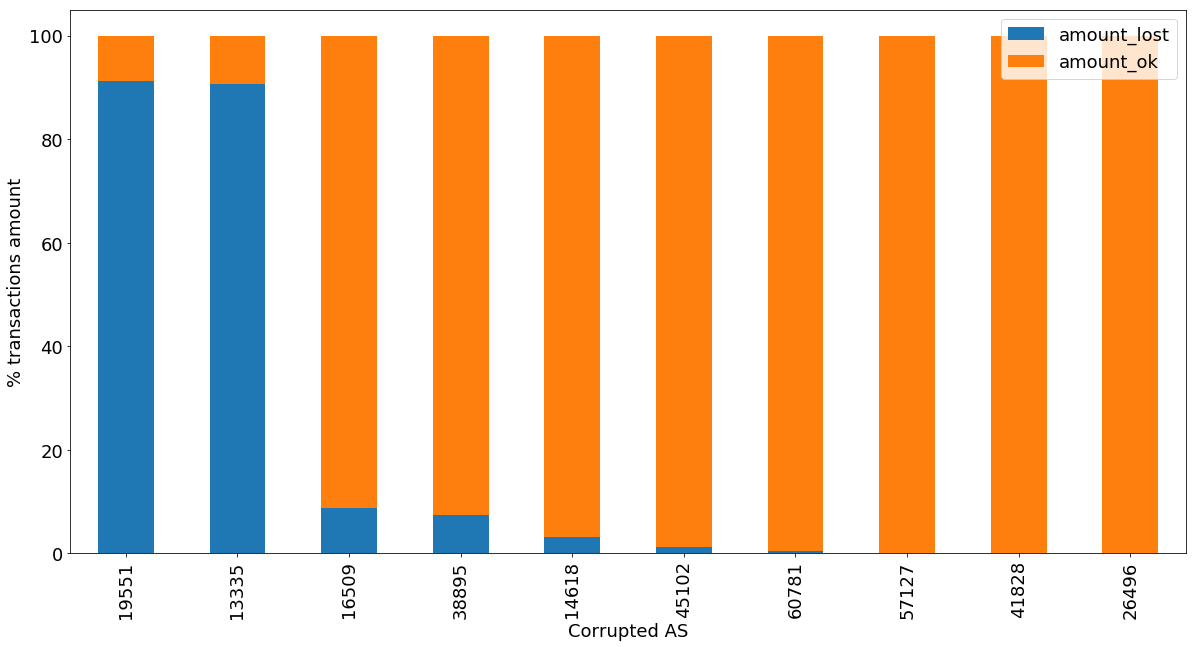

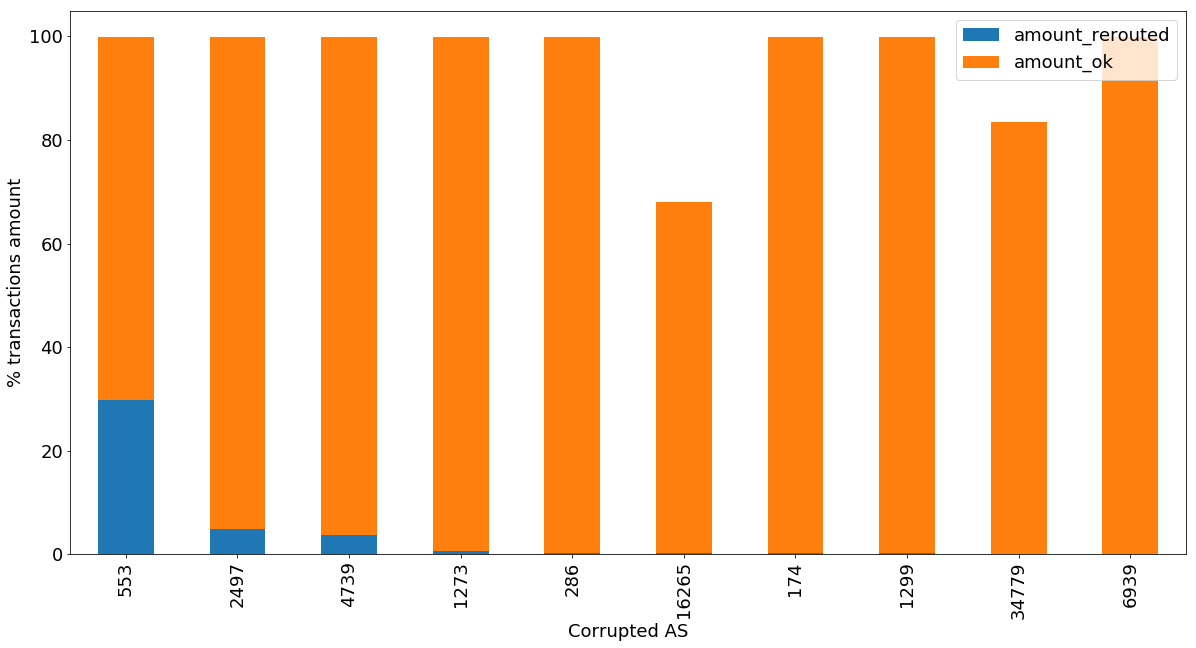

In [26]:
remove_plot[['amount_lost','amount_ok']].sort_values(by='amount_lost',ascending=False).head(10).plot.bar(stacked=True, figsize=(20,10), fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.xlabel('Corrupted AS', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('report/remove-compare-bar.eps', format='eps')
remove_plot[['amount_rerouted','amount_ok']].sort_values(by='amount_rerouted',ascending=False).head(10).plot.bar(stacked=True, figsize=(20,10), fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.xlabel('Corrupted AS', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('report/remove-rerouted-bar.eps', format='eps')

# What if there is BGP hijacking?

In [27]:
hijack_list = []
for i in range(len(months)):
    hijack_list.append(generate_hijack_analysis(graphs_list[i],transactions_list[i],best_paths_list[i]).set_index('corrupted'))

In [28]:
hijack_result = reduce(lambda x, y: x.add(y, fill_value=0), hijack_list)

In [29]:
## Visualisation
hijack_plot = hijack_result.copy()
hijack_plot['amount_ok'] = hijack_plot['amount_ok'].apply(lambda x: x*100/transactions['amount'].sum())
hijack_plot['amount_lost'] = hijack_plot['amount_lost'].apply(lambda x: x*100/transactions['amount'].sum())
hijack_plot['amount_rerouted'] = hijack_plot['amount_rerouted'].apply(lambda x: x*100/transactions['amount'].sum())

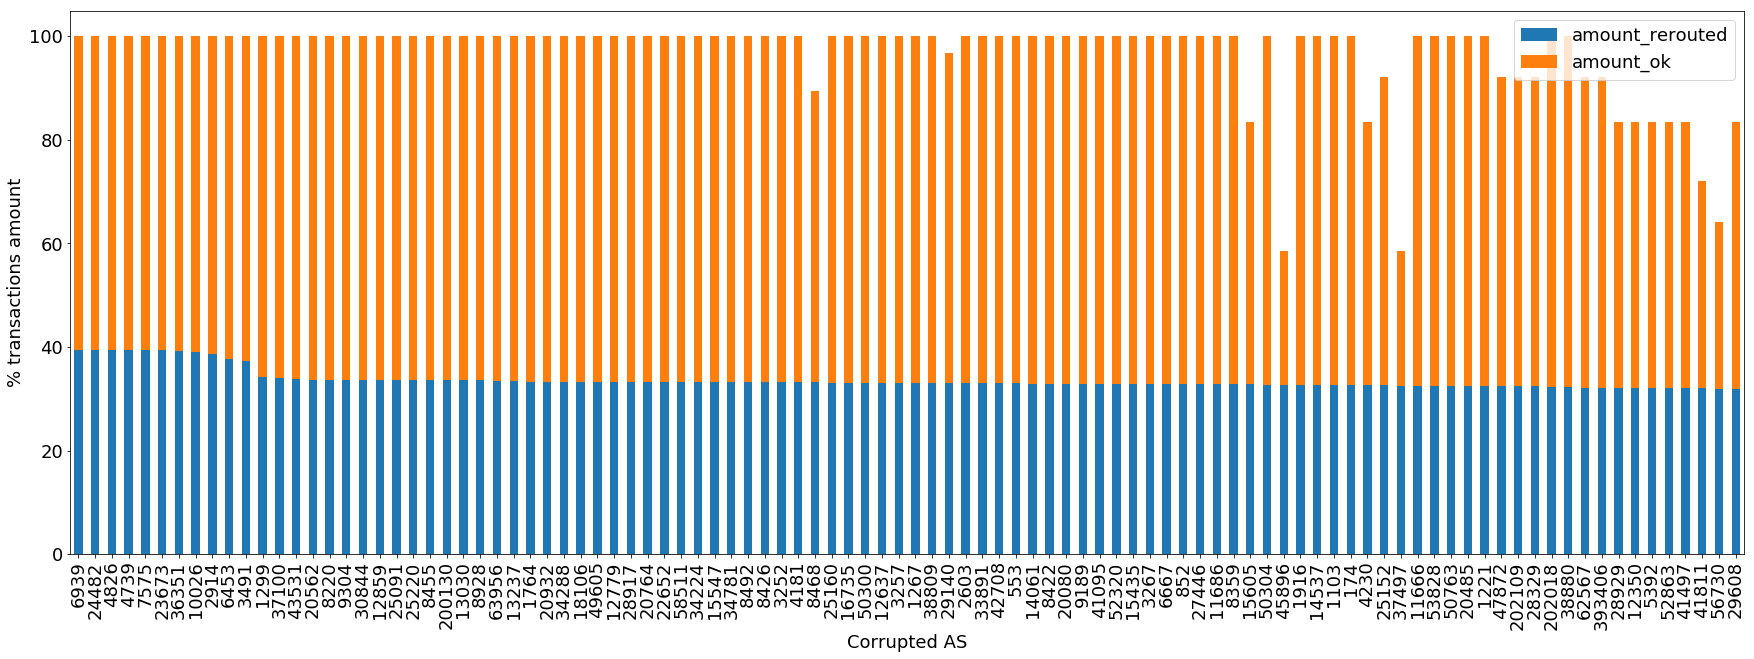

In [30]:
hijack_plot[['amount_rerouted','amount_ok']].sort_values(by='amount_rerouted',ascending=False).head(100).plot.bar(stacked=True,figsize=(30,10), fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.xlabel('Corrupted AS', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('report/hijack-bar.eps', format='eps')

# How does the attacks evolve in time?

## Case 1 : AS Down

In [31]:
def generate_top(result_list, result_total, months_list, transactions_list):
    df_top_5 = pd.DataFrame(columns=['amount_ok','amount_lost','amount_rerouted','month'])

    for i in range(len(result_list)):
        r = result_list[i]
        m = months_list[i]
        t = transactions_list[i]
        
        amount_ok = r['amount_ok'].sum()
        amount_rerouted = r['amount_rerouted'].sum()
        amount_lost = r['amount_lost'].sum()
        total = amount_ok + amount_rerouted + amount_lost
        df_top_5 = df_top_5.append({'amount_ok': 100*amount_ok/total, 'amount_lost': 100*amount_lost/total, 'amount_rerouted': 100*amount_rerouted/total, 'month': m}, ignore_index=True)
        
    amount_ok = result_total['amount_ok'].sum()
    amount_rerouted = result_total['amount_rerouted'].sum()
    amount_lost = result_total['amount_lost'].sum()
    total = amount_ok + amount_rerouted + amount_lost
    df_top_5 = df_top_5.append({'amount_ok': 100*amount_ok/total, 'amount_lost': 100*amount_lost/total, 'amount_rerouted': 100*amount_rerouted/total, 'month': 'total'}, ignore_index=True)
        
    return df_top_5.set_index('month')

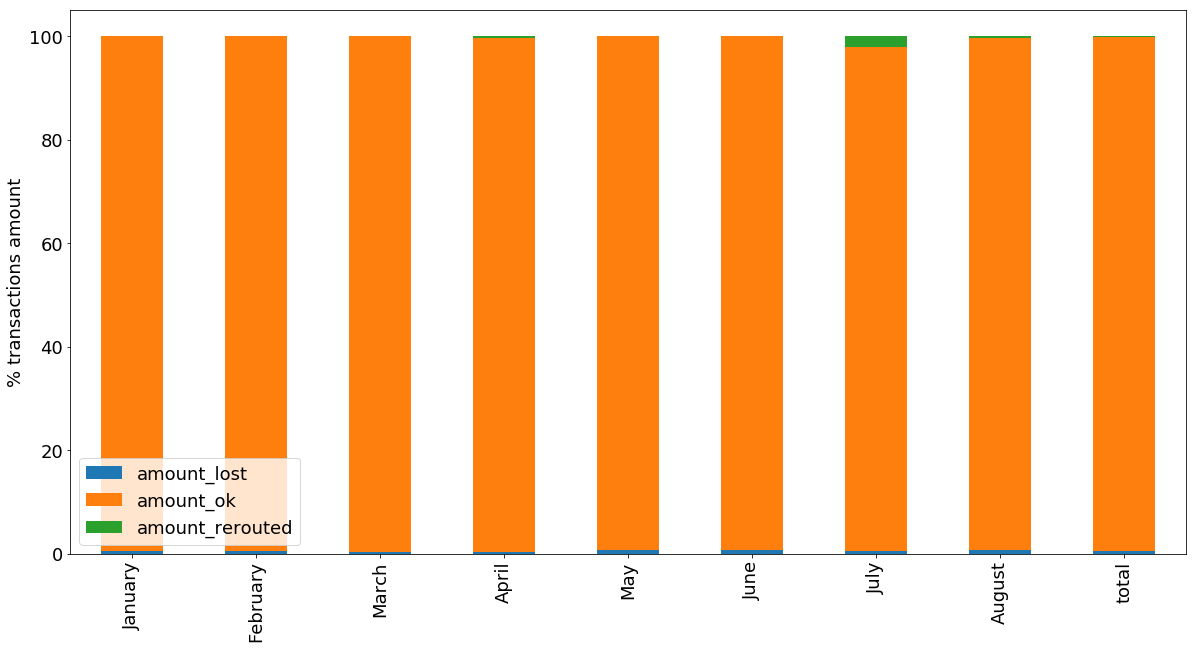

In [32]:
df_top = generate_top(remove_list, remove_result, months, transactions_list)
df_top[['amount_lost','amount_ok', 'amount_rerouted']].plot.bar(stacked=True,figsize=(20,10),fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('')
plt.savefig('report/as-time.eps', format='eps')

## Case 2 : BGP Hijacking

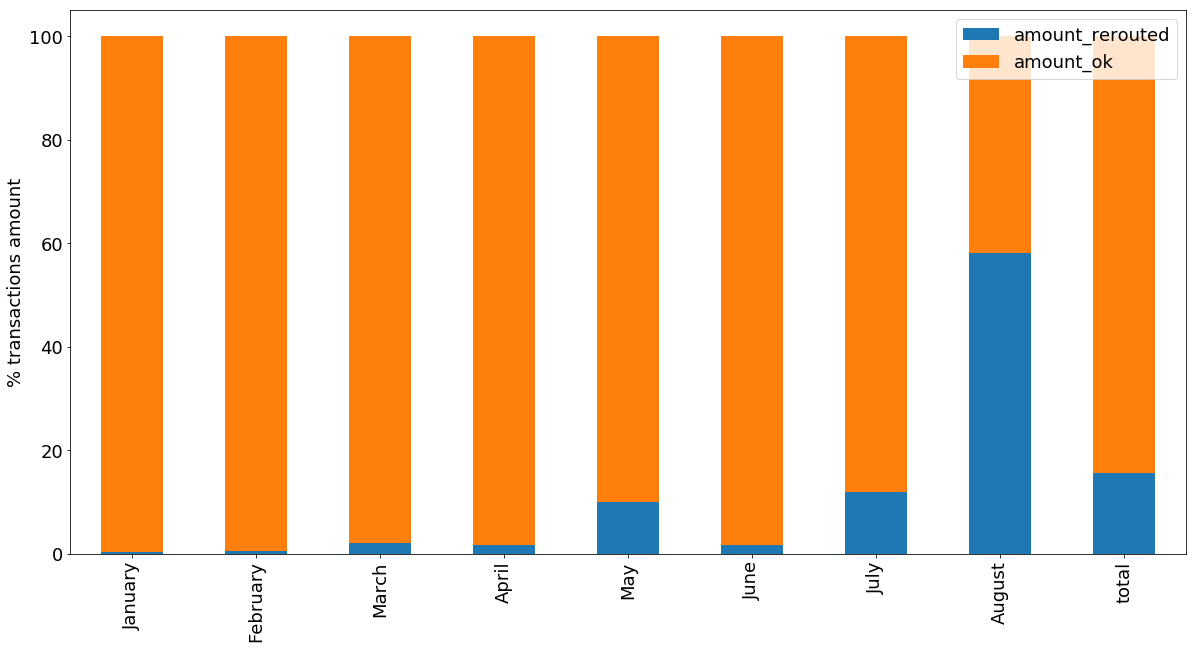

In [33]:
df_top = generate_top(hijack_list, hijack_result, months, transactions_list)
df_top[['amount_rerouted','amount_ok']].plot.bar(stacked=True,figsize=(20,10),fontsize=18)
plt.ylabel('% transactions amount', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('')
plt.savefig('report/hijack-time.eps', format='eps')

In [34]:
for i in range(len(graphs_list)):
    print('Direct link for {} : {}'.format(months[i],graphs_list[i].has_edge('13335','19551')))

Direct link for January : True
Direct link for February : True
Direct link for March : True
Direct link for April : True
Direct link for May : True
Direct link for June : True
Direct link for July : True
Direct link for August : False


In [36]:
for i in range(len(graphs_list)):
    print('16265 in {} : {}'.format(months[i],'16265' in graphs_list[i].nodes))

16265 in January : True
16265 in February : True
16265 in March : True
16265 in April : True
16265 in May : True
16265 in June : True
16265 in July : True
16265 in August : False
